Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

Paths to .csv files

In [2]:
data_dir = os.path.join("..", "data")
#fish_features = os.path.join(data_dir, "Combined_Brood_Bristol_Columbia_Fraser.csv")
fish_features = os.path.join(data_dir, "Brood_Return_First_Year_At_Sea_Tables", "Combined_Return_Bristol_Columbia_Fraser.csv")
pancea_features = os.path.join(data_dir, "GENERATED_pacea_series_annual.csv")
sst_df = os.path.join(data_dir, "sst_april_july_by_region.csv")
sss_df = os.path.join(data_dir, "sss_aprjun_mayaug_by_region.csv")
#sss_fraser_df = os.path.join(data_dir, "Fraser_River/Departure_Bay_PBS/Departure_Bay_PBS_-_Average_Monthly_Sea_Surface_Salinities_1914-2025.csv")
spawner_df = os.path.join(data_dir, "reforecastcompetitionsalmondatamobilization", "GENERATED_FullDataSet_LongForm.csv")

Load feature sheets

In [3]:
fish_df = pd.read_csv(fish_features)
pancea_df = pd.read_csv(pancea_features)
sst_df = pd.read_csv(sst_df)
sss_df = pd.read_csv(sss_df)
#sss_fraser_df = pd.read_csv(sss_fraser_df, skiprows=1)
spawner_df = pd.read_csv(spawner_df, skiprows=3)

Prepare fish_df

In [4]:
# Rename ReturnYear for clarity
fish_df = fish_df.rename(columns={'ReturnYear': 'Year'})

# Ensure years are sorted before shifting
fish_df = fish_df.sort_values(by=['System', 'River', 'Year'])

# Create prediction target: next year's Total_Returns
fish_df['Total_Returns_NextYear'] = fish_df.groupby(['System', 'River'])['Total_Returns'].shift(-1)

# Merge with climate/ocean features (PANCEA)
combined_df = fish_df.merge(pancea_df, how='left', on='Year')

Merge with SST data

In [5]:
sst_suffix_map = {
    "Bristol Bay": "BristolBay",
    "Columbia River": "ColumbiaRiver",
    "Fraser River": "FraserRiver"
}

combined_df["sst_aprjul"] = pd.NA
combined_df["sst_anom"] = pd.NA

for i, row in combined_df.iterrows():
    system = row["System"]
    year = row["Year"]
    
    if system in sst_suffix_map:
        suffix = sst_suffix_map[system]
        sst_row = sst_df[sst_df["year"] == year]
        
        if not sst_row.empty:
            combined_df.at[i, "sst_aprjul"] = sst_row.iloc[0][f"sst_aprjul_{suffix}"]
            combined_df.at[i, "sst_anom"] = sst_row.iloc[0][f"sst_anom_{suffix}"]

Merge with SSS data

In [6]:
# Step 1: Melt sss_df to long format
sss_long = sss_df.melt(id_vars='Year', var_name='System_SSS', value_name='SSS')
# Extract system and season from the column name
sss_long[['System', 'Season']] = sss_long['System_SSS'].str.extract(r'(.+?)_sss_(\w+)$')

# Optional: Fix system names to match `combined_df`
system_mapping = {
    'BristolBay': 'Bristol Bay',
    'ColumbiaRiver': 'Columbia River',
    'FraserRiver': 'Fraser River'
}
sss_long['System'] = sss_long['System'].map(system_mapping)

# Pivot to have one row per Year-System with both aprjun and mayaug
sss_pivot = sss_long.pivot_table(index=['Year', 'System'], columns='Season', values='SSS').reset_index()
sss_pivot.columns.name = None  # Remove pandas category name
sss_pivot = sss_pivot.rename(columns={
    'aprjun': 'sss_aprjun',
    'mayaug': 'sss_mayaug'
})

# Step 2: Merge with combined_df
combined_df = pd.merge(combined_df, sss_pivot, on=['Year', 'System'], how='left')

In [7]:
# Step 1: Aggregate max spawner value per BroodYear and River
spawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()

# Step 2: Build the feature for each row in combined_df
def get_spawner_sum(row):
    year = row['Year']
    river = row['River']
    target_broodyears = [year - 2, year - 3, year - 4]

    # Extract matching rows
    matches = spawner_summary[
        (spawner_summary['River'] == river) &
        (spawner_summary['BroodYear'].isin(target_broodyears))
    ]

    # Ensure all 3 BroodYears are present and have non-NaN values
    if (
        len(matches) == 3 and
        sorted(matches['BroodYear'].tolist()) == sorted(target_broodyears) and
        matches['Total_Spawners_BroodYear'].notna().all()
    ):
        return matches['Total_Spawners_BroodYear'].sum()
    else:
        return float('nan')


# Step 3: Apply to combined_df
combined_df['total_spawners_y_minus_2_to_4'] = combined_df.apply(get_spawner_sum, axis=1)

Add sea surface salinity data and Total_Spawners_BroodYear

In [8]:
'''
sss_fraser_df.replace(999.99, np.nan, inplace=True)
# Compute average salinity for April–June and May–August
sss_fraser_df['sss_aprjun'] = sss_fraser_df[['APR', 'MAY', 'JUN']].mean(axis=1)
sss_fraser_df['sss_mayaug'] = sss_fraser_df[['MAY', 'JUN', 'JUL', 'AUG']].mean(axis=1)

sss_fraser_df = sss_fraser_df[['YEAR', 'sss_aprjun', 'sss_mayaug']]
sss_fraser_df.rename(columns={'YEAR': 'Year'}, inplace=True)

fraser_mask = combined_df['System'] == 'Fraser River'
combined_df.loc[fraser_mask, ['sss_aprjun', 'sss_mayaug']] = combined_df[fraser_mask].merge(
    sss_fraser_df, how='left', on='Year')[['sss_aprjun', 'sss_mayaug']].values
'''
'''
spawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()
combined_df = combined_df.merge(
    spawner_summary,
    how='left',
    left_on=['Year', 'River'],
    right_on=['BroodYear', 'River']
)
'''

"\nspawner_summary = spawner_df.groupby(['BroodYear', 'River'], as_index=False)['Total_Spawners_BroodYear'].max()\ncombined_df = combined_df.merge(\n    spawner_summary,\n    how='left',\n    left_on=['Year', 'River'],\n    right_on=['BroodYear', 'River']\n)\n"

Get the 2024 samples for final predictions and save them in a separate file

In [9]:
subset_2024 = combined_df[combined_df['Year'] == 2024].copy()
output_path = os.path.join(data_dir, "Samples_2024.csv")
subset_2024.to_csv(output_path, index=False)

Drop rows where target is missing (i.e., last year of each group) and index column and Check for constant columns

In [10]:
combined_df = combined_df.dropna(subset=['Total_Returns_NextYear'])
combined_df = combined_df.drop(columns=["Unnamed: 0"])

constant_cols = [col for col in combined_df.columns if combined_df[col].nunique() <= 1]
if constant_cols:
    print("Columns with only one unique value (consider dropping):")
    print(constant_cols)
else:
    print("No constant columns found.")

No constant columns found.


Correlation matrix

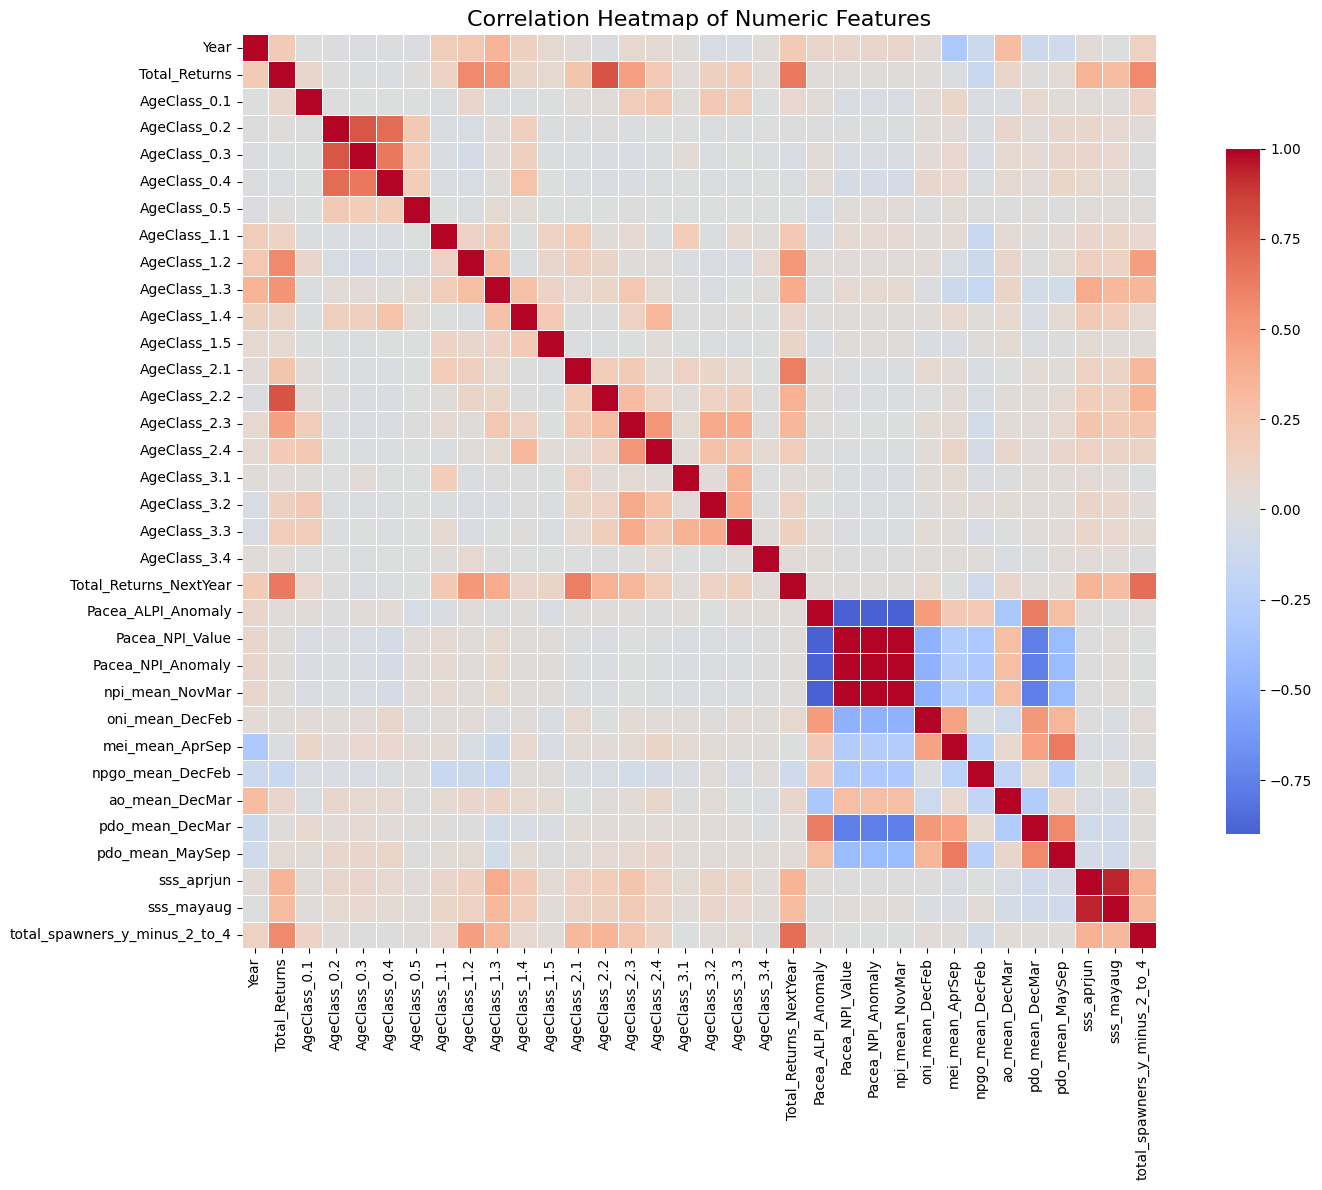

In [11]:
numeric_df = combined_df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Generate the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()

Identify and print highly correlated feature pairs

In [12]:
def find_highly_correlated_features(corr_matrix, threshold=0.9):
    correlated_pairs = []
    to_remove = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                correlated_pairs.append((col1, col2, corr_value))
                to_remove.add(col2)  # Arbitrarily keep col1 and suggest removing col2
    return correlated_pairs, to_remove

high_corr_pairs, features_to_remove = find_highly_correlated_features(correlation_matrix, threshold=0.9)

# Print correlated pairs
print("\nHighly correlated feature pairs (|correlation| > 0.9):")
for col1, col2, corr_val in high_corr_pairs:
    print(f"{col1} <--> {col2} | correlation: {corr_val:.2f}")

# Print features to consider removing
print("\nFeatures to consider removing due to high correlation:")
for feature in sorted(features_to_remove):
    print(f"- {feature}")


Highly correlated feature pairs (|correlation| > 0.9):
Pacea_NPI_Anomaly <--> Pacea_NPI_Value | correlation: 1.00
npi_mean_NovMar <--> Pacea_NPI_Value | correlation: 1.00
npi_mean_NovMar <--> Pacea_NPI_Anomaly | correlation: 1.00
sss_mayaug <--> sss_aprjun | correlation: 0.94

Features to consider removing due to high correlation:
- Pacea_NPI_Anomaly
- Pacea_NPI_Value
- sss_aprjun


Drop highly correlated or redundant columns

In [13]:
columns_to_drop = ['Pacea_NPI_Anomaly', 'Pacea_NPI_Value', 'sss_aprjun']
combined_df.drop(columns=columns_to_drop, inplace=True)

print(f"Dropped columns: {columns_to_drop}")

Dropped columns: ['Pacea_NPI_Anomaly', 'Pacea_NPI_Value', 'sss_aprjun']


Export to .csv

In [14]:
output_path = os.path.join(data_dir, "Combined_FeatureSet_For_Model.csv")
combined_df.to_csv(output_path, index=False)

num_samples = combined_df.shape[0]
num_features = combined_df.shape[1] - 1  # Exclude target variable if desired


print(f"Combined dataset saved to {output_path} with {num_samples} samples and {num_features} features.")

Combined dataset saved to ..\data\Combined_FeatureSet_For_Model.csv with 892 samples and 34 features.


Save separate files for each system

In [15]:
for system in combined_df['System'].unique():
    system_df = combined_df[combined_df['System'] == system].copy()
    system_df = system_df.drop(columns=["System"])

    # Compute correlation matrix for numeric features only
    numeric_cols = system_df.select_dtypes(include=[np.number]).columns
    feature_cols = [col for col in numeric_cols]
    corr_matrix = system_df[feature_cols].corr()

    # Identify highly correlated pairs
    high_corr_pairs = []
    for i in range(len(feature_cols)):
        for j in range(i + 1, len(feature_cols)):
            corr = corr_matrix.iloc[i, j]
            if abs(corr) >= 0.9:
                high_corr_pairs.append((feature_cols[i], feature_cols[j], round(corr, 3)))

    # Print results
    if high_corr_pairs:
        print(f"Highly correlated features in {system}:")
        for feat1, feat2, corr_val in high_corr_pairs:
            print(f"  {feat1} <--> {feat2}: correlation = {corr_val}")
    else:
        print(f"No highly correlated features (|r| ≥ 0.9) found in {system}.")

        
    # Drop specific correlated features for each system
    if system == "Columbia River":
        drop_cols = ['AgeClass_1.2', 'AgeClass_3.3']
        system_df = system_df.drop(columns=[col for col in drop_cols if col in system_df.columns])

    elif system == "Fraser River":
        drop_cols = ['AgeClass_1.2', 'Pacea_ALPI_Anomaly']
        system_df = system_df.drop(columns=[col for col in drop_cols if col in system_df.columns])
    
    # Save cleaned file
    system_path = os.path.join(data_dir, f"{system.replace(' ', '')}_FeatureSet_For_Model.csv")
    system_df.to_csv(system_path, index=False)

    sys_samples = system_df.shape[0]
    sys_features = system_df.shape[1] - 1

    print(f"{system} dataset saved to {system_path} with {sys_samples} samples and {sys_features} features.")

No highly correlated features (|r| ≥ 0.9) found in Bristol Bay.
Bristol Bay dataset saved to ..\data\BristolBay_FeatureSet_For_Model.csv with 488 samples and 33 features.
Highly correlated features in Columbia River:
  Total_Returns <--> AgeClass_1.2: correlation = 0.992
  AgeClass_3.1 <--> AgeClass_3.3: correlation = 0.989
Columbia River dataset saved to ..\data\ColumbiaRiver_FeatureSet_For_Model.csv with 39 samples and 31 features.
Highly correlated features in Fraser River:
  Total_Returns <--> AgeClass_1.2: correlation = 0.998
  Pacea_ALPI_Anomaly <--> npi_mean_NovMar: correlation = -0.904
Fraser River dataset saved to ..\data\FraserRiver_FeatureSet_For_Model.csv with 365 samples and 31 features.
